# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Read-imcat-output-final.cat" data-toc-modified-id="Read-imcat-output-final.cat-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read imcat output final.cat</a></div><div class="lev1 toc-item"><a href="#Create-new-columns" data-toc-modified-id="Create-new-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create new columns</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-without-bucketing-for-flux-vs-gm**2" data-toc-modified-id="Fitting-cubic-function-without-bucketing-for-flux-vs-gm**2-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting cubic function without bucketing for flux vs gm**2</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-without-bucketing-for-flux-vs-gc**2" data-toc-modified-id="Fitting-cubic-function-without-bucketing-for-flux-vs-gc**2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting cubic function without bucketing for flux vs gc**2</a></div><div class="lev1 toc-item"><a href="#Fitting-cubic-function-after-bucketing" data-toc-modified-id="Fitting-cubic-function-after-bucketing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fitting cubic function after bucketing</a></div><div class="lev1 toc-item"><a href="#Polynomial-Fitting-for-gm-vs-flux-after-bucketing" data-toc-modified-id="Polynomial-Fitting-for-gm-vs-flux-after-bucketing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Polynomial Fitting for gm vs flux after bucketing</a></div><div class="lev1 toc-item"><a href="#Polynomial-fitting-for-gc-vs-flux-after-bucketing" data-toc-modified-id="Polynomial-fitting-for-gc-vs-flux-after-bucketing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Polynomial fitting for gc vs flux after bucketing</a></div><div class="lev1 toc-item"><a href="#Outputs" data-toc-modified-id="Outputs-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Outputs</a></div>

# Introduction

Date: June 20, 2019

1. In jedisim we used ngals = 10k, z = 1.5 and did 100 simulations. jedisim gives l,l9,m,m9 for each 100 simulations.
2. In dmstack we create l.csv from l.fits and so on for 100*4 files, this file has 90 flags and 76 parameters.
3. After dmstack we clean and filter l.csv to get l.txt which have no nans, e <= 1.5,
   not psf candidate and have no child.
   This file has only few columns: id, x-y, errx-erry, e1-e2, sdssFlux.
4. We use these four l.txt, l9.txt, m.txt, m9.txt file in IMCAT and get final0.cat and combine 100 finalxx.cat to get 
   final.cat.
5. This lc catalog file final.cat has more columns than original 8 columns.
   ```
   id    00 10 20 30
   flux  00 10 20 30

   x  0 1
   gm 0 1
   gc 0 1
   
   errx 00 01 10 11 20 21 30 31
   g    00 01 10 11 20 21 30 31 # there is no erry here in imcat output
   
   So, in total there are
   2 * 4 + 3 * 2 + 2 * 8 = 8 + 6 + 16 = 30 columns in final.cat file.
   ```
   
   
**Purpose**  
We want to test whether the e^2 is equally distributed in different flux bins of final.cat.
We will divide flux in multiple bins and find mean(e^2) and mean(flux) for each bins and try to get a fitting function.
   

# Read imcat output final.cat

In [1]:
!head -2 final_text.txt

#       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]          gm[0]          gm[1]          gc[0]          gc[1]
            5678           5735           5568           5678      1969.2159      2159.7569         0.1046         0.0759         0.1063         0.0745         0.1055         0.0759          0.107         0.0746          1.083        -0.2341         1.1499        -0.4244         1.1705        -0.2617         1.2105        -0.4458      8119.9753      8214.5911      8109.6423      8206.3494        1.11645       -0.32925         1.1905       -0.35375


In [2]:
# find number of lines
!wc -l final_text.txt

  183837 final_text.txt


In [3]:
!tail -2 final_text.txt

            7429           7423           7347           7327      628.17332      3170.7007         0.0252         0.0236         0.0136         0.0172         0.0174         0.0145         0.0137         0.0173         0.4518        -0.5612        -0.4099         0.6419         0.4638         -0.575        -0.4214         0.6486      65430.341      65042.717      65522.963      65130.234        0.02095        0.04035         0.0212         0.0368
            3565            487           3546            486      1012.9914      668.48905         0.1321         0.1634         0.2443         0.2245         0.1336         0.1664          0.165         0.1341         0.0185          0.745         0.3311         0.3349         0.0605         0.7665         0.3397         0.3455      7363.0329      8192.7381      7288.0971       7581.061         0.1748        0.53995         0.2001          0.556


In [4]:
# Now we will read file using pandas

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# columns names
infile = 'final_text.txt'
headers = pd.read_csv(infile,sep=r'\s+',nrows=1).columns

headers = headers[1:] # remove first # column
headers

Index(['id[0][0]', 'id[1][0]', 'id[2][0]', 'id[3][0]', 'x[0]', 'x[1]',
       'errx[0][0]', 'errx[0][1]', 'errx[1][0]', 'errx[1][1]', 'errx[2][0]',
       'errx[2][1]', 'errx[3][0]', 'errx[3][1]', 'g[0][0]', 'g[0][1]',
       'g[1][0]', 'g[1][1]', 'g[2][0]', 'g[2][1]', 'g[3][0]', 'g[3][1]',
       'flux[0][0]', 'flux[1][0]', 'flux[2][0]', 'flux[3][0]', 'gm[0]',
       'gm[1]', 'gc[0]', 'gc[1]'],
      dtype='object')

In [7]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None)
df.columns = headers
print(df.shape)
df.head(2).append(df.tail(2)).T

(183836, 30)


,0,1,183834,183835
id[0][0],5678.00000,3181.00000,7429.00000,3565.00000
id[1][0],5735.00000,3193.00000,7423.00000,487.00000
id[2][0],5568.00000,3164.00000,7347.00000,3546.00000
id[3][0],5678.00000,3179.00000,7327.00000,486.00000
x[0],1969.21590,2222.70820,628.17332,1012.99140
x[1],2159.75690,480.46175,3170.70070,668.48905
errx[0][0],0.10460,0.00840,0.02520,0.13210
errx[0][1],0.07590,0.00800,0.02360,0.16340
errx[1][0],0.10630,0.00780,0.01360,0.24430
errx[1][1],0.07450,0.00860,0.01720,0.22450


# Create new columns

In [8]:
# Find total flux, gm**2 and gc**2
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2
df.head()

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,...,8214.5911,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375,32650.5581,1.354866,1.542429
1,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,...,53844.2740,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530,215540.1590,0.012645,0.011600
2,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,...,2009.3786,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255,7989.1430,0.304864,0.257543
3,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,...,6547.4142,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215,26208.0764,0.029548,0.058387
4,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,...,5059.5502,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555,20687.7608,0.001252,0.001265


In [9]:
# we want to find flux buckets, so sort the data by flux
df = df.sort_values(by='flux')
df.head(2).append(df.tail(2))

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
180836,7597,7587,7519,7501,2193.6307,3159.44600,0.3857,0.3846,0.4108,0.4646,...,8.597343e+02,8.518551e+02,8.422593e+02,0.06375,-0.13935,0.13805,-0.21480,3.517335e+03,0.023482,0.065197
24586,3241,3245,3259,3255,1177.8090,467.15318,0.2720,0.3329,0.3182,0.3392,...,1.123866e+03,1.166863e+03,1.051554e+03,0.35400,0.14165,0.16295,0.23625,4.517341e+03,0.145381,0.082367
44153,5092,5093,5067,5058,1864.7449,1676.20600,0.0006,0.0009,0.0006,0.0010,...,1.112796e+06,1.092244e+06,1.111720e+06,-0.93000,0.03850,-0.95505,0.05265,4.410982e+06,0.866382,0.914893
182110,1343,1357,1365,1381,1752.4989,1823.38120,0.0017,0.0012,0.0009,0.0006,...,1.510224e+06,1.523726e+06,1.520149e+06,0.82035,-0.52500,0.81545,-0.54430,6.084687e+06,0.948599,0.961221


In [10]:
df.shape

(183836, 33)

In [135]:
df.flux.describe()

count    1.838360e+05
mean     1.408643e+05
std      2.657454e+05
min      3.517335e+03
25%      1.771650e+04
50%      3.720871e+04
75%      1.160867e+05
max      6.084687e+06
Name: flux, dtype: float64

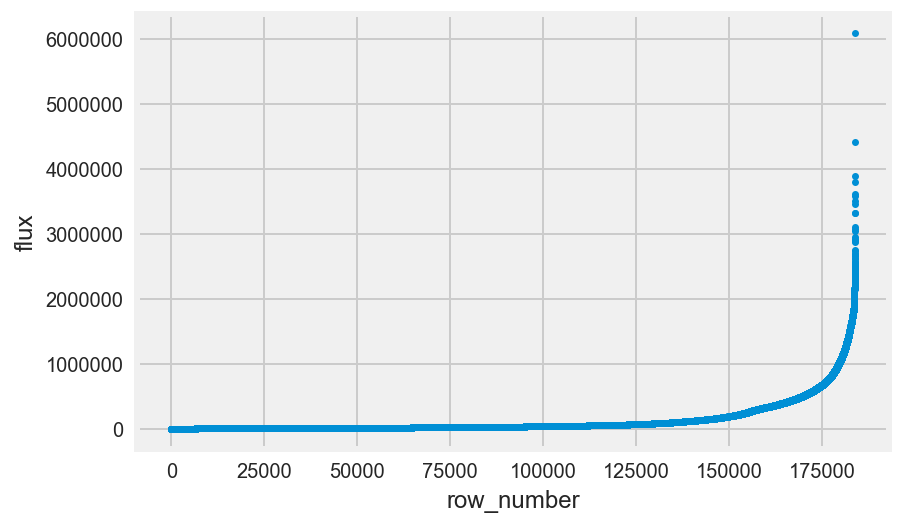

In [139]:
plt.plot(df.flux.values,'.')
plt.xlabel('row_number')
plt.ylabel('flux')

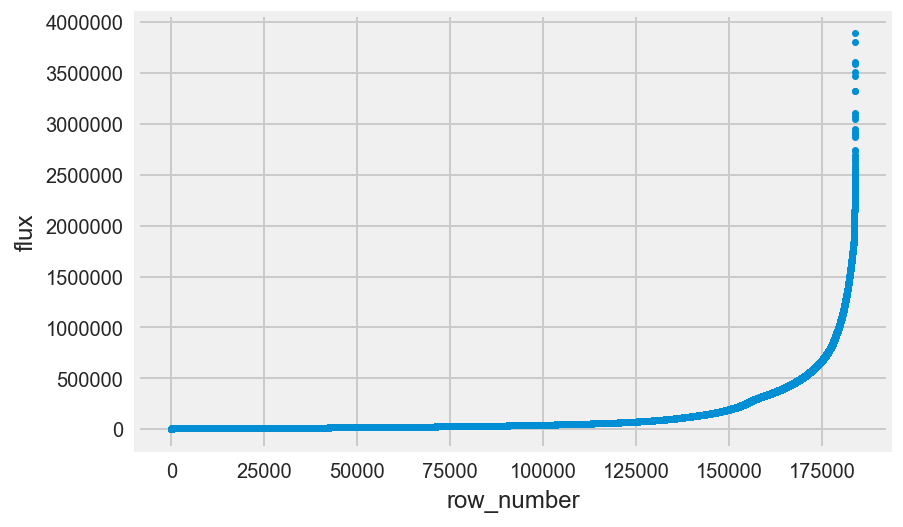

In [141]:
# looks like two data points are outliers, remove them
df = df.query('flux < 4e6')
plt.plot(df.flux.values,'.')
plt.xlabel('row_number')
plt.ylabel('flux')

In [142]:
N_BUCKETS = 30
df['flux_bin'] = pd.cut(df.flux, bins=N_BUCKETS, labels=False)
df.head(2).append(df.tail(2)).iloc[:,-5:]

,gc_sq,flux_bin,flux_bin_mean_gm_sq,flux_bin_mean_gc_sq,flux_bin_mean_flux
180836,0.065197,0,0.315938,0.322123,4.442059e+04
24586,0.082367,0,0.315938,0.322123,4.442059e+04
80278,0.827968,29,0.843333,0.827968,3.806006e+06
71103,0.818372,29,0.815898,0.818372,3.889998e+06


In [143]:
# Note that not all the bins have values
# they are divided with equal flux sum, not by number of rows.
temp = N_BUCKETS -1
df.query('flux_bin == @temp')

,id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],...,gm[1],gc[0],gc[1],flux,gm_sq,gc_sq,flux_bin,flux_bin_mean_gm_sq,flux_bin_mean_gc_sq,flux_bin_mean_flux
80278,5133,5111,5125,5121,1872.0278,1769.3216,0.0008,0.0010,0.0007,0.0010,...,-0.72725,-0.56210,-0.71555,3806006.39,0.843333,0.827968,29,0.843333,0.827968,3806006.39
71103,4878,4889,4900,4883,1721.7061,1565.6212,0.0055,0.0019,0.0058,0.0031,...,0.18415,0.88575,0.18390,3889998.23,0.815898,0.818372,29,0.815898,0.818372,3889998.23


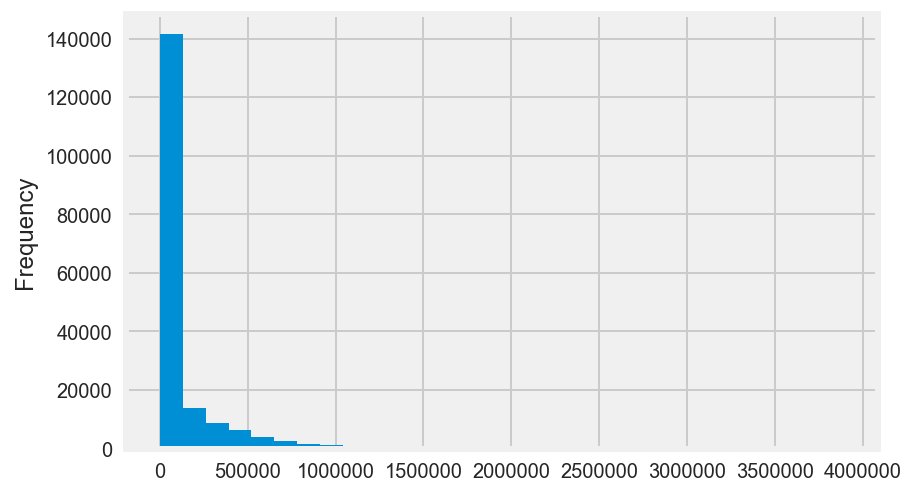

In [144]:
df.flux.plot.hist(N_BUCKETS)

In [149]:
df.iloc[:5,-5:]

,gc_sq,flux_bin,flux_bin_mean_gm_sq,flux_bin_mean_gc_sq,flux_bin_mean_flux
180836,0.065197,0,0.323353,0.329551,36169.504788
24586,0.082367,0,0.323353,0.329551,36169.504788
169317,0.032798,0,0.323353,0.329551,36169.504788
53346,0.167132,0,0.323353,0.329551,36169.504788
137696,0.963135,0,0.323353,0.329551,36169.504788


# Fitting cubic function without bucketing for flux vs gm**2

array([ -5.74135019e-20,   4.33159258e-13,  -7.16880305e-07,
         3.40963718e-01])

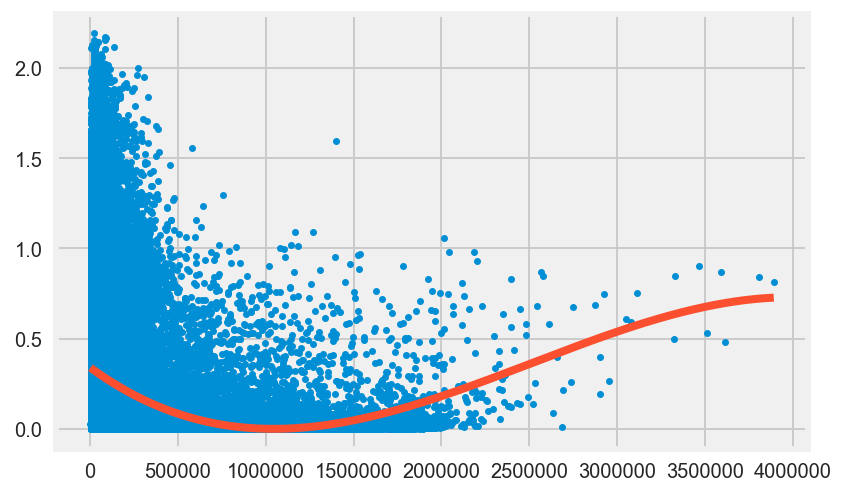

In [158]:
x = df['flux'].values
y = df['gm_sq'].values

z = np.polyfit(x,y,3)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')


gm_no_buckets = p.coeffs
gm_no_buckets

# Fitting cubic function without bucketing for flux vs gc**2

array([ -5.64600247e-20,   4.33941935e-13,  -7.21976523e-07,
         3.47180962e-01])

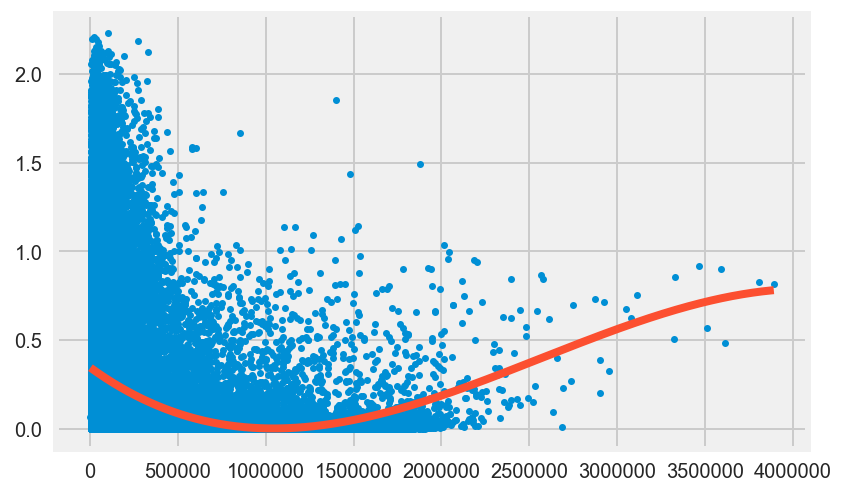

In [159]:
x = df['flux'].values
y = df['gc_sq'].values

z = np.polyfit(x,y,3)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gc_no_buckets = p.coeffs
gc_no_buckets

# Fitting cubic function after bucketing
```
p(x) = p[0] * x**deg + ... + p[deg]
p(x) = ax**3 + bx**2 + cx + d

z = np.polyfit(x,y,3)
p = np.poly1d(z)
a = p(0)
d = p(-1)

```

In [151]:
# create new columns gm**2 gc**2 and flux for each bins
df['flux_bin_mean_gm_sq'] = df.groupby('flux_bin')['gm_sq'].transform('mean')
df['flux_bin_mean_gc_sq'] = df.groupby('flux_bin')['gc_sq'].transform('mean')
df['flux_bin_mean_flux'] = df.groupby('flux_bin')['flux'].transform('mean')
df.iloc[:5,-8:]

,gc[1],flux,gm_sq,gc_sq,flux_bin,flux_bin_mean_gm_sq,flux_bin_mean_gc_sq,flux_bin_mean_flux
180836,-0.21480,3517.3354,0.023482,0.065197,0,0.323353,0.329551,36169.504788
24586,0.23625,4517.3414,0.145381,0.082367,0,0.323353,0.329551,36169.504788
169317,0.08615,4635.8814,0.062990,0.032798,0,0.323353,0.329551,36169.504788
53346,-0.40020,4705.8241,0.183463,0.167132,0,0.323353,0.329551,36169.504788
137696,-0.81485,4717.4109,0.995355,0.963135,0,0.323353,0.329551,36169.504788


In [152]:
# confirm first bin values
bin1 = df.query('flux_bin == 0')
bin1.gm_sq.mean()

0.3233528841387166

In [153]:
# take only mean gm gc flux in each buckets, and take unique values
gm_gc_flux = df[['flux_bin_mean_gm_sq', 'flux_bin_mean_gc_sq', 'flux_bin_mean_flux']].drop_duplicates()
gm_gc_flux.columns = ['gm','gc','flux']
gm_gc_flux

,gm,gc,flux
180836,0.323353,0.329551,3.616950e+04
23299,0.197824,0.203180,1.850304e+05
114230,0.086962,0.090766,3.293991e+05
98543,0.050810,0.053291,4.516968e+05
29805,0.046026,0.048501,5.811807e+05
55731,0.044931,0.046479,7.100716e+05
56898,0.055904,0.059859,8.406654e+05
201,0.054203,0.056365,9.731027e+05
54738,0.057344,0.060293,1.101241e+06
134966,0.048709,0.051394,1.232770e+06


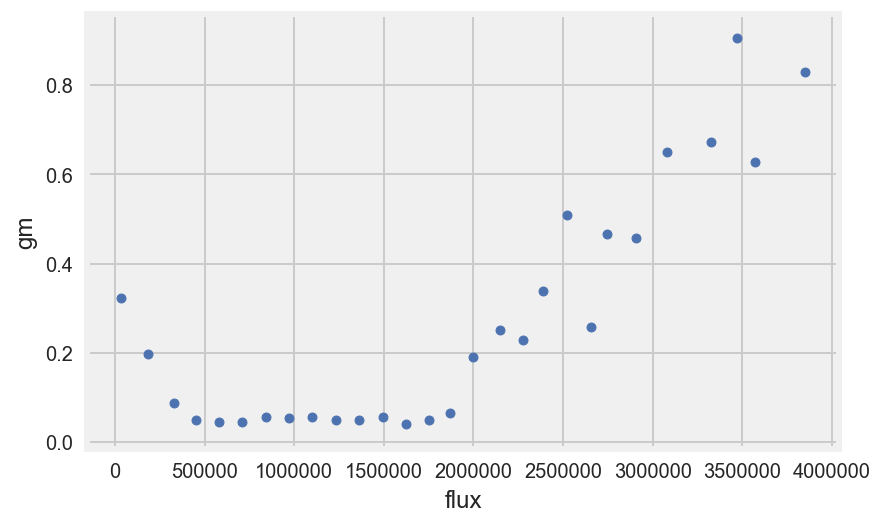

In [154]:
gm_gc_flux.plot.scatter(x='flux',y='gm')

# Polynomial Fitting for gm vs flux after bucketing

array([ -4.24697483e-20,   3.58803463e-13,  -6.11607762e-07,
         3.05308587e-01])

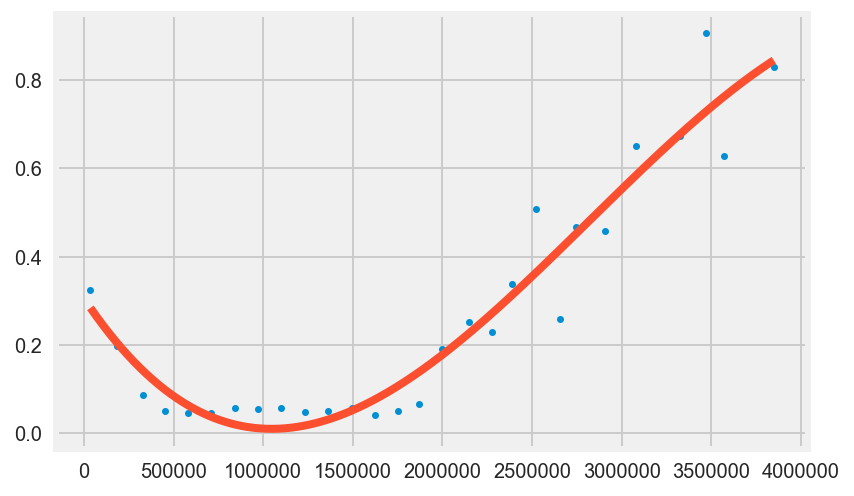

In [160]:
x = gm_gc_flux['flux'].values
y = gm_gc_flux['gm'].values

z = np.polyfit(x,y,3)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gm_buckets = p.coeffs
gm_buckets

# Polynomial fitting for gc vs flux after bucketing

array([ -4.58533069e-20,   3.77506542e-13,  -6.35017858e-07,
         3.14779327e-01])

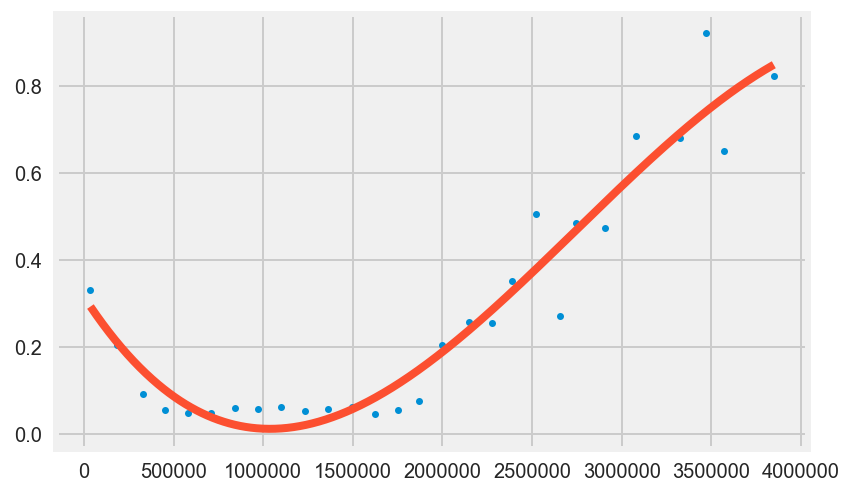

In [163]:
x = gm_gc_flux['flux'].values
y = gm_gc_flux['gc'].values

z = np.polyfit(x,y,3)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, '.', xp, p(xp), '-')

gc_buckets = p.coeffs
gc_buckets

# Outputs

- number of buckets used = 30
- there are two flux values are are extremely high, which can be excluded.

In [165]:
parameters = pd.DataFrame({'gm_no_buckets': gm_no_buckets,
                          'gc_no_buckets': gc_no_buckets,
                          'gm_buckets': gm_buckets,
                          'gc_buckets': gc_buckets})

parameters.index = list('abcd')
print('fitting: ax**3 + bx**2 + cx + d')

parameters

fitting: ax**3 + bx**2 + cx + d


,gc_buckets,gc_no_buckets,gm_buckets,gm_no_buckets
a,-4.585331e-20,-5.646002e-20,-4.585331e-20,-5.741350e-20
b,3.775065e-13,4.339419e-13,3.775065e-13,4.331593e-13
c,-6.350179e-07,-7.219765e-07,-6.350179e-07,-7.168803e-07
d,3.147793e-01,3.471810e-01,3.147793e-01,3.409637e-01
